In [1]:
from pathlib import Path 
from tqdm import tqdm 
import torchvision
import cv2 
import numpy as np 
import torch 
import os
import torch.nn as nn
from torch import long, tensor 
from torch.utils.data.dataset import Dataset 
from torchvision.transforms import Compose, ToTensor
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
batch_size = 16
classes = ['Non-Masked', 'Masked']

In [2]:
torch.cuda.empty_cache()

In [3]:
data_path = Path(r'C:/Users/world/Desktop/511Finalpjt/data_set')
maskPath = data_path/'with_mask'
nonMaskPath = data_path/'without_mask' 
path_dirs = [ [maskPath,1],[nonMaskPath,0] ] #path and label

In [4]:
class MaskvNoMask():
    LABELS = {'NON_MASKED': 0, 'MASKED': 0}
    training_data = []
    def make_training_data(self):
        for data_dir,label in path_dirs:
            for folder in tqdm(list(data_dir.iterdir())):
                folder_path = os.path.join(data_dir,folder)
                #try:
                #print(folder_path)
                img = cv2.imread(folder_path)
                img = cv2.resize(img, (100,100))
                self.training_data.append([np.array(img), label])
                #except :
                        #print(folder_path)

                if label == 0:
                    self.LABELS['NON_MASKED'] +=1
                if label == 1:
                    self.LABELS['MASKED'] += 1

        print(self.LABELS)
        np.random.shuffle(self.training_data)

In [5]:
maskvnomask = MaskvNoMask()
maskvnomask.make_training_data()     
training_data = maskvnomask.training_data   

100%|█████████████████████████████████████████████████████████████████████████████| 3801/3801 [00:33<00:00, 115.08it/s]

{'NON_MASKED': 3801, 'MASKED': 3769}


In [6]:
class MaskDataset(Dataset):
        """ Masked faces dataset        0 = 'no mask'     1 = 'mask'       """
        def __init__(self, train_data):
            self.train_data = train_data
            self.transformations = Compose([
                ToTensor()        ])
        
        def __getitem__(self, key):
            if isinstance(key, slice):
                raise NotImplementedError('slicing is not supported')                    
            return [
                self.transformations(self.train_data[key][0]),
                torch.tensor(self.train_data[key][1]) # pylint: disable=not-callable
            ]
        
        def __len__(self):
            return len(self.train_data)

In [7]:
myDataset = MaskDataset(training_data)
myDataset[5]

[tensor([[[0.0000, 0.0235, 0.0627,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0235, 0.0627,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0314, 0.0667,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0196, 0.0392,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0039, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],
 
         [[0.0000, 0.0235, 0.0627,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0235, 0.0627,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0314, 0.0667,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0196, 0.0392,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0039, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],
 
         [[0.0000, 0.0235, 0.0627,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0235, 0.0627,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0314, 0.0667,  ...,

In [8]:
val_size = 800
train_size = len(myDataset) - val_size

train_ds, val_ds = torch.utils.data.random_split(myDataset, [train_size, val_size])
len(train_ds), len(val_ds)

(6770, 800)

In [9]:
img, label = myDataset[1001]
print(img.shape)
print(label)

torch.Size([3, 100, 100])
tensor(1)


Label:  Masked (1)


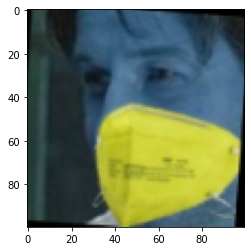

In [10]:
def show_example(data):
    img, label = data
    print('Label: ', classes[int(label.item())], "("+str(label.item())+")")
    plt.imshow(img.permute(1, 2, 0))
show_example(val_ds[77])

In [11]:
train_dl = DataLoader(train_ds, batch_size*2,shuffle=True)
val_dl = DataLoader(val_ds, batch_size*2)

tensor([0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 0, 0, 1, 1, 0])


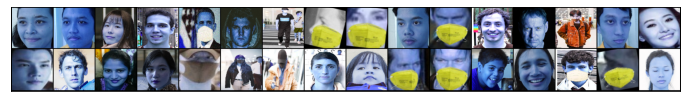

In [12]:
def show_batch(dl):
    for images, labels in dl:
        print(labels)
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)

tensor([0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 0])


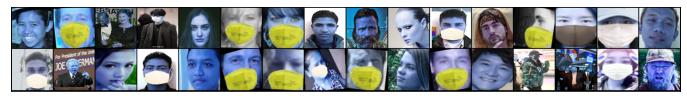

In [13]:
show_batch(val_dl)

In [14]:
def accuracy(outputs, labels):
    #_, preds = torch.max(outputs, dim=1)
    for i in range(len(outputs)):
        if outputs[i]>=0.5:
            outputs[i]=1
        else: outputs[i]=0
    return torch.tensor(torch.sum(outputs == labels).item() / len(outputs))       
    #return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)# Generate predictions
        loss = F.binary_cross_entropy(torch.squeeze(torch.sigmoid(out)), labels.float()) # Calculate loss
        #loss=F.cross_entropy(out, labels.long()) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.binary_cross_entropy(torch.squeeze(torch.sigmoid(out)), labels.float())
        #loss = F.cross_entropy(out, labels.long()) # Calculate loss
        #acc = accuracy(out, labels)
        acc = accuracy(torch.squeeze(torch.sigmoid(out)), labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [16]:
class MaskDetection(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(160000, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1))
        
    def forward(self, xb):
        return self.network(xb)

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
device

device(type='cuda')

In [18]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [19]:
for images, labels in val_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    print(labels.shape)
    break

torch.Size([32, 3, 100, 100])
cuda:0
torch.Size([32])


In [20]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999),lr=0.001)
    for epoch in range(epochs):
        # Training Phase 
        print('epoch: ', epoch)
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [23]:
# Model (on GPU)
model = MaskDetection()
to_device(model, device)

MaskDetection(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten()
    (11): Linear(in_features=160000, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=256, bias=True)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [24]:
model.eval()

MaskDetection(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten()
    (11): Linear(in_features=160000, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=256, bias=True)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [25]:
sum(p.numel() for p in model.parameters())

83055473

In [26]:
[evaluate(model, val_dl)]

[{'val_loss': 0.693073034286499, 'val_acc': 0.4987500011920929}]

In [27]:
history = fit(10, 1e-3, model, train_dl, val_dl)

epoch:  0
Epoch [0], train_loss: 0.1769, val_loss: 0.1287, val_acc: 0.9463
epoch:  1
Epoch [1], train_loss: 0.1404, val_loss: 0.1483, val_acc: 0.9438
epoch:  2
Epoch [2], train_loss: 0.1018, val_loss: 0.1283, val_acc: 0.9438
epoch:  3
Epoch [3], train_loss: 0.1009, val_loss: 0.0998, val_acc: 0.9663
epoch:  4
Epoch [4], train_loss: 0.0838, val_loss: 0.1056, val_acc: 0.9600
epoch:  5
Epoch [5], train_loss: 0.0778, val_loss: 0.1182, val_acc: 0.9500
epoch:  6
Epoch [6], train_loss: 0.0672, val_loss: 0.0963, val_acc: 0.9575
epoch:  7
Epoch [7], train_loss: 0.0825, val_loss: 0.1206, val_acc: 0.9575
epoch:  8
Epoch [8], train_loss: 0.0708, val_loss: 0.0928, val_acc: 0.9712
epoch:  9
Epoch [9], train_loss: 0.0602, val_loss: 0.1005, val_acc: 0.9663


In [28]:
torch.save(model.state_dict(), r'C:\Users\world\Desktop\511Finalpjt\detection\.pth')

In [82]:
import matplotlib.image as mpimg
def singleImage(path, label= None, show= False):
    img = cv2.imread(path)
    assert img is not None,"Immage wasn't read properly"
    face_cascade = cv2.CascadeClassifier(r"C:\Users\world\Desktop\511Finalpjt\haarcascade_frontalface_alt.xml")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    for (i, (x, y, w, h)) in enumerate(faces): 
        cv2.rectangle(img, (x, y), (x+1*w, y+1*h), (220, 90, 230), 3)      
        img=img[y:y+h,x:x+w]
        plt.imshow(img)
        img = cv2.resize(img, (100, 100))
        img = torch.from_numpy(img)
        img = img.permute((2, 0,1)) # model expects image to be of shape [3, 100, 100]
        img = img.unsqueeze(dim=0).float() # convert single image to batch [1, 3, 100, 100]
        img = img.to('cuda') # Using the same device as the model
        pred = model(img)
        _, preds = torch.max(pred, dim=1)
        print(classes[preds.item()])

        if show:
            print("the image is :" + classes[preds.item()])

Non-Masked
the image is :Non-Masked


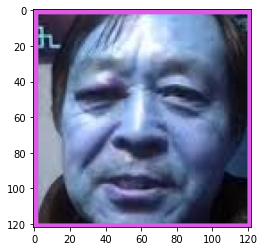

In [83]:
singleImage(r"C:\Users\world\Desktop\511Finalpjt\detection\231.jpg",show=True)

Non-Masked
the image is :Non-Masked


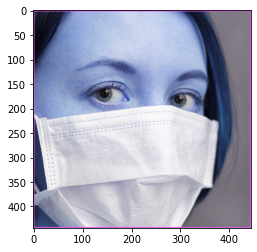

In [84]:
singleImage(r"C:\Users\world\Desktop\511Finalpjt\detection\MASKY.jpg",show=True)

Non-Masked
the image is :Non-Masked


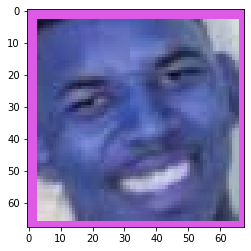

In [86]:
singleImage(r"C:\Users\world\Desktop\511Finalpjt\detection\images.jpg",show=True)

Non-Masked
the image is :Non-Masked


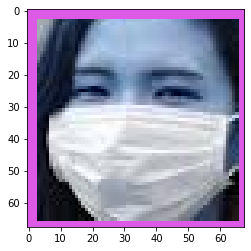

In [77]:
singleImage(r"C:\Users\world\Desktop\511Finalpjt\detection\213213123.jpg",show=True)